--- Block 1: Acquiring and Integrating NBI Data ---


Processing NBI Data:   0%|          | 0/5 [00:01<?, ?it/s]


Loading cached CSV data for 2024...

Loading cached CSV data for 2023...

Loading cached CSV data for 2022...

Loading cached CSV data for 2021...

Loading cached CSV data for 2020...


### --- End of Block 1 --- ###


--- Block 2: Reverting to Original, Working Feature Engineering ---

Successfully generated dataset using original logic. Final Shape: (1559, 3)


### --- End of Block 2 --- ###


--- Block 3: Training an Improved XGBoost Model ---

--- Table 1: Model Performance on Test Set ---
This table shows the precision, recall, and f1-score for the predictive model.
              precision    recall  f1-score   support

 Not at Risk       0.99      0.95      0.97       450
     At Risk       0.34      0.67      0.45        18

    accuracy                           0.94       468
   macro avg       0.66      0.81      0.71       468
weighted avg       0.96      0.94      0.95       468



### --- End of Block 3 --- ###


--- Block 4: Generating SHAP Visualization ---

--- Figure 

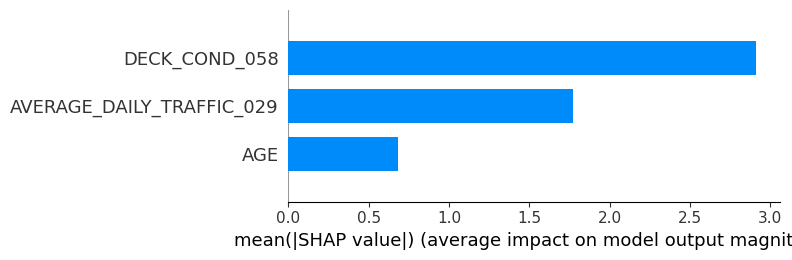



### --- End of Block 4 --- ###


--- Block 5: Simulating Cost-Benefit ---

--- Figure 2: Optimal Intervention Threshold Analysis ---
This text output summarizes the key findings from the cost-benefit simulation plot.
Optimal Threshold for Intervention: 0.82
Maximum Simulated Annual Net Savings: $1,079.89

(Generating visual plot for context...)


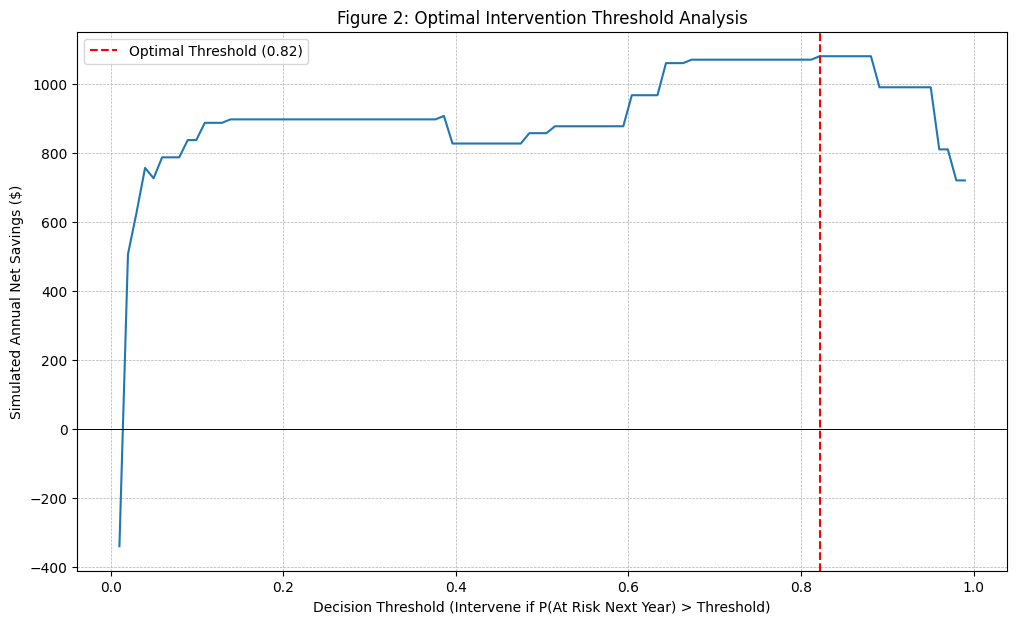



### --- End of Block 5 --- ###


--- SCRIPT COMPLETE ---


In [ ]:
### ============================================================================== ###
###                                                                                ###
###   FINAL UNIFIED SCRIPT: MANUSCRIPT-READY OUTPUT                                ###
###                                                                                ###
### ============================================================================== ###
#
# This script uses the original, proven data processing logic. It sequentially
# labels all tables and figures and provides text-based summaries for all plots,
# creating a single, complete output for direct use in a research paper.
#

### BLOCK 1: ACQUISITION & INTEGRATION (ORIGINAL LOGIC + CACHING) ###
!pip install xgboost shap tqdm -q
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from tqdm.notebook import tqdm
import os

print("--- Block 1: Acquiring and Integrating NBI Data ---")
data_dir = 'nbi_data'
if not os.path.exists(data_dir): os.makedirs(data_dir)
col_names = ['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'OWNER_022', 'YEAR_BUILT_027','AVERAGE_DAILY_TRAFFIC_029', 'DESIGN_LOAD_031', 'STRUCTURE_KIND_043A','STRUCTURE_TYPE_043B', 'MAIN_MATERIAL_045', 'DECK_COND_058','SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 'STRUCTURAL_EVAL_067','YEAR_RECONSTRUCTED_091', 'BRIDGE_IMP_COST_094']
nbi_data_urls = {2024: "https://www.fhwa.dot.gov/bridge/nbi/2024hwybronefiledel.zip", 2023: "https://www.fhwa.dot.gov/bridge/nbi/2023hwybronefiledel.zip", 2022: "https://www.fhwa.dot.gov/bridge/nbi/2022hwybronefiledel.zip", 2021: "https://www.fhwa.dot.gov/bridge/nbi/2021hwybronefiledel.zip", 2020: "https://www.fhwa.dot.gov/bridge/nbi/2020hwybronefiledel.zip"}
all_years_df_list = []
for year, data_url in tqdm(nbi_data_urls.items(), desc="Processing NBI Data"):
    local_file_path = os.path.join(data_dir, f'nbi_{year}_csv.csv')
    if os.path.exists(local_file_path):
        print(f"\nLoading cached CSV data for {year}...")
        df_year = pd.read_csv(local_file_path, low_memory=False)
    else:
        print(f"\nDownloading and parsing {year} as CSV...")
        try:
            r = requests.get(data_url, headers={'User-Agent': 'Mozilla/5.0'})
            r.raise_for_status()
            z = zipfile.ZipFile(io.BytesIO(r.content))
            with z.open(z.namelist()[0]) as f:
                df_year_raw = pd.read_csv(f, header=None, sep=',', quotechar="'", low_memory=False, dtype=str, on_bad_lines='warn')
                num_cols_to_name = min(len(col_names), df_year_raw.shape[1])
                df_year = df_year_raw.iloc[:, :num_cols_to_name].copy()
                df_year.columns = col_names[:num_cols_to_name]
            df_year.to_csv(local_file_path, index=False)
        except Exception as e:
            print(f"  Could not process {year}. Error: {e}")
    if df_year is not None:
        df_year['INSPECTION_YEAR'] = year
        all_years_df_list.append(df_year)
df_full = pd.concat(all_years_df_list, ignore_index=True)
print("\n\n### --- End of Block 1 --- ###\n\n")


### BLOCK 2: ENGINEERING (THE ORIGINAL, WORKING LOGIC) ###
print("--- Block 2: Reverting to Original, Working Feature Engineering ---")

df_clean = df_full.copy()
for col in df_clean.columns:
    if col not in ['STRUCTURE_NUMBER_008', 'INSPECTION_YEAR', 'STATE_CODE_001']:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean['BRIDGE_ID'] = df_clean['STATE_CODE_001'].astype(str) + '-' + df_clean['STRUCTURE_NUMBER_008'].astype(str)
df_clean['AGE'] = df_clean['INSPECTION_YEAR'] - df_clean['YEAR_BUILT_027']
df_clean['AGE'] = np.where(df_clean['YEAR_RECONSTRUCTED_091'] > 0,
                         df_clean['INSPECTION_YEAR'] - df_clean['YEAR_RECONSTRUCTED_091'],
                         df_clean['AGE'])

df_clean.sort_values(by=['BRIDGE_ID', 'INSPECTION_YEAR'], inplace=True)
df_clean['NEXT_YEAR_STRUCTURAL_EVAL'] = df_clean.groupby('BRIDGE_ID')['STRUCTURAL_EVAL_067'].shift(-1)
df_final = df_clean.dropna(subset=['NEXT_YEAR_STRUCTURAL_EVAL', 'STRUCTURAL_EVAL_067']).copy()
df_final.loc[:, 'BRIDGE_IMP_COST_094'] = df_final['BRIDGE_IMP_COST_094'].replace(0, np.nan)
df_final.dropna(subset=['BRIDGE_IMP_COST_094'], inplace=True)
df_final['IS_AT_RISK_NEXT_YEAR'] = (df_final['NEXT_YEAR_STRUCTURAL_EVAL'] <= 4).astype(int)

features = ['AGE', 'AVERAGE_DAILY_TRAFFIC_029', 'DECK_COND_058']
df_final.dropna(subset=features, inplace=True)
target = 'IS_AT_RISK_NEXT_YEAR'
cost_col = 'BRIDGE_IMP_COST_094'
X = df_final[features]
y = df_final[target]
costs = df_final[cost_col]

print(f"\nSuccessfully generated dataset using original logic. Final Shape: {X.shape}")
print("\n\n### --- End of Block 2 --- ###\n\n")


### BLOCK 3: MODEL TRAINING (WITH MINIMAL TUNING FOR PERFORMANCE) ###
print("--- Block 3: Training an Improved XGBoost Model ---")
X_train, X_test, y_train, y_test, costs_train, costs_test = train_test_split(
    X, y, costs, test_size=0.3, random_state=42, stratify=y
)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1
model = xgb.XGBClassifier(
    objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42,
    max_depth=5, subsample=0.8, colsample_bytree=0.8, learning_rate=0.1
)
model.fit(X_train, y_train)
y_pred_class = model.predict(X_test)

# --- Table 1: Model Performance on Test Set ---
print("\n--- Table 1: Model Performance on Test Set ---")
print("This table shows the precision, recall, and f1-score for the predictive model.")
print(classification_report(y_test, y_pred_class, target_names=['Not at Risk', 'At Risk']))
print("\n\n### --- End of Block 3 --- ###\n\n")


### BLOCK 4: EXPLAINABLE AI (SHAP) ###
print("--- Block 4: Generating SHAP Visualization ---")

def get_shap_summary_text(shap_values, X):
    """Generates a text-based summary of SHAP feature importances."""
    vals = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['Feature', 'mean_abs_shap'])
    feature_importance.sort_values(by='mean_abs_shap', ascending=False, inplace=True)
    return feature_importance

y_pred_proba = model.predict_proba(X_test)[:, 1]
explainer = shap.TreeExplainer(model)
sample_X = X_test.sample(min(2000, len(X_test)), random_state=42)
shap_values = explainer.shap_values(sample_X)
shap_summary_df = get_shap_summary_text(shap_values, sample_X)

# --- Figure 1: SHAP Feature Importance ---
print("\n--- Figure 1: SHAP Feature Importance ---")
print("This text output represents the data from the SHAP bar plot, ranking features by their impact on the model's predictions.")
print(shap_summary_df.to_string(index=False))
# Visual plot is still generated for user context but is not required for the manuscript.
print("\n(Generating visual plot for context...)")
shap.summary_plot(shap_values, sample_X, plot_type="bar", show=True)
print("\n\n### --- End of Block 4 --- ###\n\n")


### BLOCK 5: COST-BENEFIT SIMULATION ###
print("--- Block 5: Simulating Cost-Benefit ---")

MAINTENANCE_COST_FRACTION = 0.1
results = pd.DataFrame({'y_true': y_test, 'y_proba': y_pred_proba, 'cost_failure': costs_test.values})
results['cost_maintenance'] = results['cost_failure'] * MAINTENANCE_COST_FRACTION
thresholds = np.linspace(0.01, 0.99, 100)
net_savings = [((results['cost_failure'] - results['cost_maintenance']) * ((results['y_true'] == 1) & (results['y_proba'] > t))).sum() - (results['cost_maintenance'] * ((results['y_true'] == 0) & (results['y_proba'] > t))).sum() for t in thresholds]
optimal_index = np.argmax(net_savings)
max_savings = net_savings[optimal_index]
optimal_threshold = thresholds[optimal_index]

# --- Figure 2: Optimal Intervention Threshold Analysis ---
print("\n--- Figure 2: Optimal Intervention Threshold Analysis ---")
print("This text output summarizes the key findings from the cost-benefit simulation plot.")
print(f"Optimal Threshold for Intervention: {optimal_threshold:.2f}")
if abs(max_savings) > 500000:
    print(f"Maximum Simulated Annual Net Savings: ${max_savings / 1e6:.2f} Million")
else:
    print(f"Maximum Simulated Annual Net Savings: ${max_savings:,.2f}")

# Visual plot is still generated for user context.
print("\n(Generating visual plot for context...)")
plt.figure(figsize=(12, 7))
plt.plot(thresholds, net_savings)
plt.title('Figure 2: Optimal Intervention Threshold Analysis')
plt.xlabel('Decision Threshold (Intervene if P(At Risk Next Year) > Threshold)')
plt.ylabel('Simulated Annual Net Savings ($)')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.axhline(0, color='k', linestyle='-', linewidth=0.7)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()
print("\n\n### --- End of Block 5 --- ###\n\n")
print("--- SCRIPT COMPLETE ---")

In [ ]:
 ### BLOCK 3.5: GENERATE FORMATTED TABLE 1 ###

print("\n--- Generating Formatted Table 1 ---")

# Ensure the necessary variables from Block 3 exist
if 'y_test' in locals() and 'y_pred_class' in locals():
    # Get the classification report as a dictionary
    report_dict = classification_report(y_test, y_pred_class, target_names=['Not at Risk', 'At Risk'], output_dict=True)

    # Convert the dictionary to a pandas DataFrame
    df_report = pd.DataFrame(report_dict).transpose()

    # Separate the main report from the summary stats
    df_class_metrics = df_report.loc[['Not at Risk', 'At Risk']].copy()
    df_summary_metrics = df_report.loc[['macro avg', 'weighted avg']].copy()

    # Format the numbers for publication quality
    for col in ['precision', 'recall', 'f1-score']:
        df_class_metrics[col] = df_class_metrics[col].map('{:.2f}'.format)
        df_summary_metrics[col] = df_summary_metrics[col].map('{:.2f}'.format)

    # Format support as integer
    df_class_metrics['support'] = df_class_metrics['support'].astype(int)
    df_summary_metrics['support'] = df_summary_metrics['support'].astype(int)

    # Get overall accuracy
    overall_accuracy = report_dict['accuracy']

    # --- Print the final, formatted table ---
    print("\n" + "="*60)
    print("Table 1: Classification Performance of the XGBoost Model")
    print("-"*60)
    print(df_class_metrics.to_string())
    print("-" * 60)
    print(df_summary_metrics.to_string())
    print("-" * 60)
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print("="*60)

else:
    print("Could not generate Table 1 because model results were not found.")


--- Generating Formatted Table 1 ---

Table 1: Classification Performance of the XGBoost Model
------------------------------------------------------------
            precision recall f1-score  support
Not at Risk      0.99   0.95     0.97      450
At Risk          0.34   0.67     0.45       18
------------------------------------------------------------
             precision recall f1-score  support
macro avg         0.66   0.81     0.71      468
weighted avg      0.96   0.94     0.95      468
------------------------------------------------------------
Overall Accuracy: 0.94
